In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle



    Only loading the 'en' tokenizer.



In [2]:
PATH='data/sentiment140/'

TRN_PATH = 'train/'
VAL_PATH = 'test/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'
os.makedirs(TRN, exist_ok=True)
os.makedirs(VAL, exist_ok=True)
%ls {TRN}

In [3]:
!ls {PATH}

models				Sentiment-Analysis-Dataset.zip	train
Sentiment-Analysis-Dataset.csv	test


In [4]:
TEXT = data.Field(lower=True, tokenize=spacy_tok) # word-level

In [4]:
TEXT = data.Field(lower=True, tokenize=list) # character-level: list('abc') = ['a', 'b', 'c']

In [5]:
bs=32; bptt=70

In [6]:
df = pd.read_csv(f'{PATH}Sentiment-Analysis-Dataset.csv', skiprows=lambda x: x in [8835, 535881])

In [7]:
df.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [8]:
n = len(df)

In [9]:
idxs = get_cv_idxs(n)
val_df = df.iloc[idxs].set_index("ItemID")
samp_size = len(val_df); samp_size

315722

In [10]:
df.to_csv(f'{PATH}train/train2_sentiment140.csv')
val_df.to_csv(f'{PATH}test/test2_sentiment140.csv')

In [6]:
df = pd.read_csv(f'{PATH}train/train2_sentiment140.csv')
val_df = pd.read_csv(f'{PATH}test/test2_sentiment140.csv')

In [11]:
md = LanguageModelData.from_dataframes(PATH, TEXT, 'SentimentText', df, val_df, test_df=val_df, bs=bs, bptt=bptt, min_freq=10)

In [12]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT_CHAR_TOKEN.pkl','wb'))

In [13]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(53297, 152, 1, 119387724)

In [14]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', ' ', 'e', 't', 'o', 'a', 'i', 'n', 's', 'r', 'h']

In [16]:
TEXT.vocab.stoi['a']

6

In [17]:
md.trn_ds[0].text[:12]

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']

In [19]:
TEXT.numericalize([md.trn_ds[0].text[:12]])

Variable containing:
 35945
    14
    25
   132
    18
    10
     0
   267
  6611
 30438
     3
   273
[torch.cuda.LongTensor of size 12x1 (GPU 0)]

In [20]:
next(iter(md.trn_dl))

(Variable containing:
  35945      2      2  ...      62      9      8
     14      0   8551  ...       9     60   3244
     25      3     25  ...     317     31   7080
         ...            ⋱           ...         
     93      4      2  ...     104   4892      3
   1815      4   8551  ...     414    337     26
   1341      3     59  ...     219     67     74
 [torch.cuda.LongTensor of size 64x32 (GPU 0)], Variable containing:
     14
      0
   8551
   ⋮   
     10
      7
    793
 [torch.cuda.LongTensor of size 2048 (GPU 0)])

In [18]:
em_sz = 200  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

In [19]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [20]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.2, dropout=0.2, wdrop=0.1, dropoute=0.08, dropouth=0.2)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [21]:
learner.fit(3e-3, 4, wds=1e-6, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

  0%|          | 0/53297 [00:00<?, ?it/s]


NotImplementedError: 

In [44]:
learner.save_encoder('dropout_exp_1_adam3_10_enc')

In [46]:
learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 75%|███████▌  | 9022/11997 [20:21<06:42,  7.39it/s, loss=17.6]

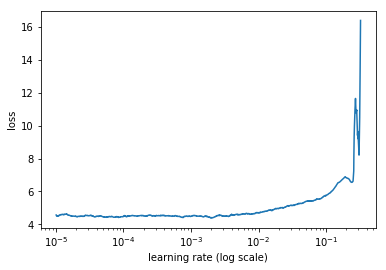

In [47]:
learner.sched.plot()

In [48]:
learner.fit(3e-3, 1, wds=1e-6, cycle_len=10, cycle_save_name='adam3_20')

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))


  0%|          | 57/11997 [00:08<28:40,  6.94it/s, loss=4.49]  

Exception in thread Thread-140:
Traceback (most recent call last):
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration
Exception in thread Thread-141:
Traceback (most recent call last):
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




[ 0.       4.65814  4.6741 ]                                    
[ 1.       4.62958  4.66611]                                    
[ 2.       4.64585  4.65608]                                    
[ 3.       4.62403  4.64216]                                    
[ 4.       4.59305  4.62979]                                    
[ 5.       4.60238  4.61219]                                    
[ 6.       4.58245  4.59518]                                    
[ 7.       4.57238  4.58309]                                    
[ 8.       4.57923  4.57875]                                    
[ 9.       4.53687  4.57855]                                    



In [49]:
learner.save_encoder('dropout_exp_2_adam3_10_enc')

In [52]:
learner.fit(3e-3, 2, wds=1e-6, cycle_len=20, cycle_save_name='adam3_20')

HBox(children=(IntProgress(value=0, description='Epoch', max=40), HTML(value='')))

[ 0.       4.55263  4.57914]                                    
[ 1.       4.63134  4.67246]                                    
[ 2.       4.63319  4.66507]                                    
[ 3.       4.65825  4.65508]                                    
[ 4.       4.64992  4.65094]                                    
[ 5.       4.64433  4.64873]                                    
[ 6.       4.64174  4.63384]                                    
[ 7.       4.58426  4.63529]                                    
[ 8.       4.60742  4.62555]                                    
[ 9.       4.59639  4.62434]                                    
[ 10.        4.584     4.61225]                                 
[ 11.        4.57332   4.60437]                                 
[ 12.        4.55848   4.58865]                                 
[ 13.        4.52542   4.58274]                                 
[ 14.        4.56124   4.57546]                                 
[ 15.        4.54774   4.

In [70]:
learner.save_encoder('dropout_exp_3_adam3_10_enc')

In [100]:
learner.save('dropout_exp_3_adam3_20_model')

In [ ]:
learner.load('dropout_exp_3_adam3_20_model')

In [95]:
m=learner.model
ss="""omg my life is """
s = [spacy_tok(ss)]
t=TEXT.numericalize(s)
' '.join(s[0])

'omg my life is'

In [96]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

In [97]:
nexts = torch.topk(res[-1], 20)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

['so',
 'over',
 '<unk>',
 'not',
 'a',
 'going',
 'really',
 'just',
 'almost',
 'too',
 "n't",
 'the',
 'like',
 'good',
 'sooo',
 'boring',
 'gon',
 'always',
 'soo',
 'killing']

In [98]:
print(ss,"\n")
for i in range(25):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

omg my life is  

so boring   i 'm so sad . i 'm so sad . i 'm so sad . i 'm so sad . i 'm ...


In [99]:
m

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(44587, 200, padding_idx=1)
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(200, 500, dropout=0.2)
      )
      (1): WeightDrop(
        (module): LSTM(500, 500, dropout=0.2)
      )
      (2): WeightDrop(
        (module): LSTM(500, 200, dropout=0.2)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouth): LockedDropout(
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=200, out_features=44587)
    (dropout): LockedDropout(
    )
  )
)

In [8]:
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))

In [9]:
SENTIMENT_LABEL = data.Field(sequential=False)

In [89]:
??LanguageModelData.from_dataframes

In [35]:
??ConcatTextDatasetFromDataFrames.splits

In [41]:
torchtext.datasets.IMDB.splits

<bound method IMDB.splits of <class 'torchtext.datasets.imdb.IMDB'>>

In [40]:
md.trn_ds.splits

<bound method ConcatTextDatasetFromDataFrames.splits of <class 'fastai.nlp.ConcatTextDatasetFromDataFrames'>>

In [10]:
class Sentiment140Dataset(torchtext.data.TabularDataset):
    @classmethod
    def splits(cls, train_df=None, val_df=None, test_df=None, **kwargs):
        train_data = None if train_df is None else cls(train_df, **kwargs)
        val_data = None if val_df is None else cls(val_df, **kwargs)
        test_data = None if test_df is None else cls(test_df, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

    @classmethod
    def splits(cls, text_field, label_field, root='.data',
               train='train', test='test', **kwargs):
        return super().splits(
            root, text_field=text_field, label_field=label_field,
            train=train, validation=None, test=test, **kwargs)

In [102]:
ls {PATH}

models/               Sentiment-Analysis-Dataset.csv*  test/  train/
sentiment140.tar.xz*  Sentiment-Analysis-Dataset.zip*  tmp/


In [12]:
ds = Sentiment140Dataset(f'{PATH}Sentiment-Analysis-Dataset.csv', 'csv', [('Sentiment', SENTIMENT_LABEL), ('SentimentText', TEXT)])

TypeError: __init__() missing 2 required positional arguments: 'format' and 'fields'

In [13]:
ds.examples

 ...]